<a href="https://colab.research.google.com/github/Apoorva100/Speech-reaction-predictor/blob/main/Speech%20reaction%20predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow pandas numpy scikit-learn


Epoch 1/5
10/10 [==============================] - 5s 122ms/step - loss: 1.4050 - accuracy: 0.2625 - val_loss: 1.4474 - val_accuracy: 0.2125
Epoch 2/5
10/10 [==============================] - 0s 11ms/step - loss: 1.3820 - accuracy: 0.2937 - val_loss: 1.3907 - val_accuracy: 0.2750
Epoch 3/5
10/10 [==============================] - 0s 13ms/step - loss: 1.3551 - accuracy: 0.3500 - val_loss: 1.4188 - val_accuracy: 0.2000
Epoch 4/5
10/10 [==============================] - 0s 14ms/step - loss: 1.3516 - accuracy: 0.3187 - val_loss: 1.4305 - val_accuracy: 0.2375
Epoch 5/5
4/4 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.28      0.26      0.27        27
           1       0.00      0.00      0.00        26
           2       0.36      0.40      0.38        25
           3       0.15      0.32      0.20        22

    accuracy                           0.24       100
   macro avg       0.20      0.24      0.21       10

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


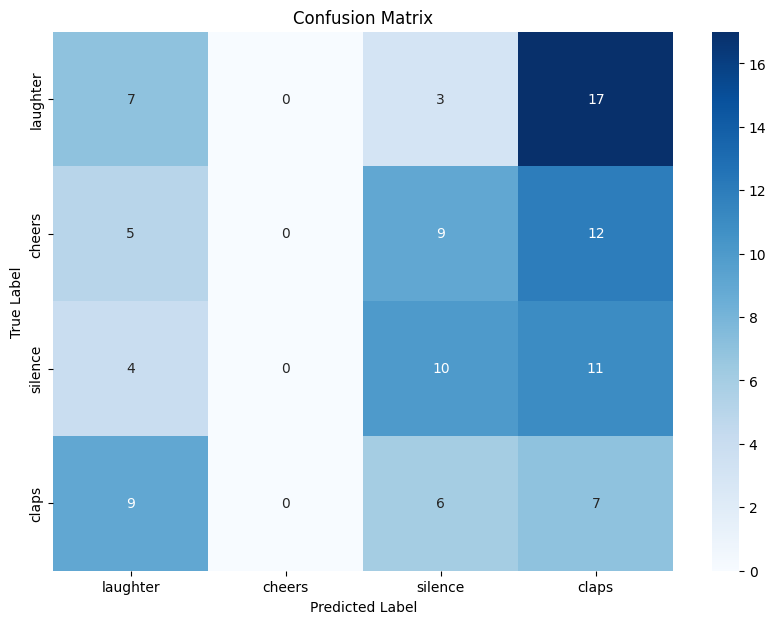

In [11]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Generate a synthetic dataset
data = {
    'speech_id': np.arange(1, 501),
    'timestamp': np.random.choice(['00:00:10', '00:01:20', '00:02:30', '00:03:40'], 500),
    'sentiment': np.random.choice(['positive', 'neutral', 'negative'], 500),
    'reaction': np.random.choice(['claps', 'laughter', 'silence', 'cheers'], 500),
    'speech_text': ['Speech content ' + str(i) for i in range(1, 501)]
}
df = pd.DataFrame(data)
df.to_csv('speeches_data.csv', index=False)

# Step 2: Load and preprocess the data


df = pd.read_csv('speeches_data.csv')
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['speech_text'])
sequences = tokenizer.texts_to_sequences(df['speech_text'])
max_length = max(len(seq) for seq in sequences)
X = pad_sequences(sequences, maxlen=max_length)

reaction_mapping = {reaction: idx for idx, reaction in enumerate(df['reaction'].unique())}
y = df['reaction'].map(reaction_mapping).values

def load_glove_embeddings(path):
    embeddings_index = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_path = '/content/glove.6B.200d.txt'  # Update this path
embeddings_index = load_glove_embeddings(glove_path)
embedding_dim = 200
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Step 3: Build and train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Bidirectional(LSTM(64)),
    Dense(len(reaction_mapping), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Step 4: Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))
conf_mat = confusion_matrix(y_test, y_pred_classes)

# Plotting confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=list(reaction_mapping.keys()), yticklabels=list(reaction_mapping.keys()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
